The Gross-Pitaevski equation is given as follows:
$$
i\hbar \frac{\partial \psi(\mathbf{r}, t)}{\partial t} = \left( - \frac{\hbar^2}{2m} \nabla^2 + V(\mathbf{r}, t) + g_{3D} N |\psi|^2 \right) \psi(\mathbf{r}, t)
$$

Where $N$ is the number of condensate atoms, $m$ is the mass of a condensate atom, $g_{3D} = 4 \pi \hbar^2 a / m$ where $a$ is the wave scattering length and $V(\mathbf{r}, t)$ is the full external potential. In the case of the Hawking radiation experiment we have that:
$$
V(\mathbf{r}, t) = U(\mathbf{r}) + U_{step}(\mathbf{r}, t)
$$
Then the Time Independent Equation for the ground state is given by:
$$
\mu_0 \psi_0(\mathbf{r}) = \left( - \frac{\hbar^2}{2m} \nabla^2 + U(\mathbf{r}) + g_{3D} N |\psi_0|^2 \right) \psi_0(\mathbf{r})
$$

Then according to the paper the potential in the experiment is given by:
$$
U(\mathbf{r}) = U_0 \left[ 1 - \left( \frac{w_0}{w(x)}\right)^2 \exp\left( \frac{-2 \rho^2}{w^2(x)} \right) \right] \text{  where  } \rho = \sqrt{y^2 + z^2}
$$
Furthermore for a Gaussian beam we have:
$$
w(x) = w_0 \sqrt{1 + \left(\frac{x}{x_0}\right)^2} \text{  where  } x_0 = \frac{\pi w_0^2}{\lambda}
$$
Then from the paper still we have that:
$$
U_0 = \frac{1}{4} m w_\rho^2 w_0^2
$$
Then the whole problem can be reduced to a 1D problem given by:
$$
i \hbar \frac{\partial \psi_{1D}}{\partial t} = \left(-\frac{\hbar^2}{2 m } \frac{\partial^2 }{\partial x^2} + V(x, t)  + g_{1D} N |\psi_{1D}|^2  \right)\psi_{1D}
$$
Then the step potential is given by:
$$
U_{step}(x, t) = - U_s \Theta(x_s(t) - x)
$$
Where $U_s$ is the step strength and $x_s(t)$ represents the step location which moves at a constant spees $v_s$.

In [1]:
import sys
!pip install cupy

  Using cached cupy-8.1.0.tar.gz (5.9 MB)


    ERROR: Command errored out with exit status 1:
     command: 'c:\python37\python.exe' -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Marco\\AppData\\Local\\Temp\\pip-install-jo7sgskw\\cupy\\setup.py'"'"'; __file__='"'"'C:\\Users\\Marco\\AppData\\Local\\Temp\\pip-install-jo7sgskw\\cupy\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\Marco\AppData\Local\Temp\pip-pip-egg-info-20lt1gul'
         cwd: C:\Users\Marco\AppData\Local\Temp\pip-install-jo7sgskw\cupy\
    Complete output (45 lines):
    Options: {'package_name': 'cupy', 'long_description': None, 'wheel_libs': [], 'wheel_includes': [], 'wheel_metadata': None, 'no_rpath': False, 'profile': False, 'linetrace': False, 'annotate': False, 'no_cuda': False, 'use_hip': False}
    
    -------- Configuring Module: cuda --------
    a.cpp
    C:\Users\Marco\App

In [142]:
import numpy as np
import scipy.linalg as linalg
import scipy.sparse as sparse
import scipy.sparse.linalg as splinalg
import matplotlib.pyplot as plt
import cupy as cp
from cupyx.scipy.sparse import csr_matrix as csr_gpu


ModuleNotFoundError: No module named 'cupy'

Now remember that Crank Nicolson is given by:
$$
\frac{u_i^{n+1} - u_i^n}{\Delta t} = \frac{1}{2} \left[ F_i^{n+1} + F_{i}^n \right]
$$
And in our case we have that:
$$
F = \frac{1}{i \hbar} \left(-\frac{\hbar^2}{2 m } \frac{\partial^2 }{\partial x^2} + V(x, t)  + g_{1D} N |\psi_{1D}|^2  \right)\psi_{1D}
$$
Which simplifies to:
$$
F_i^n = \frac{1}{i\hbar}\left( - \frac{\hbar^2}{2m} \left( \frac{u_{i+1}^n - 2 u_i^n + u_{i-1}^n}{(\Delta x)^2} \right) + U_0\left( 1 - \left(\frac{w_0}{w(i \Delta x)}\right)^2\right) u_i^n + g_{1D} N | u_i^n|^2 u_i^n \right)
$$

Now the Crank Nicolson equation can be re-written as:
$$
\frac{u_{i}^{n+1}}{\Delta t} - \frac{1}{i 2 \hbar}\left( - \frac{\hbar^2}{2m} \left( \frac{u_{i+1}^{n+1} - 2 u_i^{n+1} + u_{i-1}^{n+1}}{(\Delta x)^2} \right) + U_0\left( 1 - \left(\frac{w_0}{w(i \Delta x)}\right)^2\right) u_i^{n+1} + g_{1D} N | u_i^{n+1}|^2 u_i^{n+1} \right) = 
$$

In [101]:
def solve_GPE(xmin, xmax, tmin, tmax, dt, grid_points, im_iters):
    #hbar = 1e-34
    #k = 1.38 * 1e-23 
    hbar = 1
    k = 1
    N = 6000
    w0 = 5 * 1e-6
    lbda = 812 * 1e-9
    U0 = 39 * k 
    Us = 6 * k 
    xs = xmin
    vs = 21
    m  = 1.4 * 1e-25
    a = 2 * 1e-6
    g  = 4 * np.pi * hbar**2 * a/m
    
    x = np.linspace(xmin, xmax, grid_points)
    dx = x[1] - x[0]
    
    time_tab = np.arange(tmin, tmax, dt)
    u = np.sqrt(1/2) * (1 + 1j) * np.ones(x.shape)
    u /= np.sqrt(len(u))
    
    x0 = np.pi*w0**2/lbda
    wx = w0 * np.sqrt(1 + (x/x0)**2)
    U = U0*(1 - (w0/wx)**2)

    def potential_step(xs):
        return - Us * (x > xs)

    def potential(U0, w0, lbda, Us, xs, x):
        return potential_U(U0, w0, lbda, x) + potential_step(Us, xs, x)
    
    def create_matrix(sgn, u, V):
        alpha = hbar**2/(4 * dx**2 * m)
        beta = (1/dt - sgn*hbar**2/(2 * dx**2 * m) - \
                sgn*N*g/2 * (u * np.conjugate(u)) - sgn*V/2)
        diag = sgn*alpha*np.ones(len(beta)-1)
        out1 = np.array([np.append(0, diag), beta, np.append(diag, 0)])
        out2 = sparse.diags([beta, sgn*alpha, sgn*alpha], [0, -1, 1])
        return out1, out2
    
    '''
    Imaginary time evolution
    '''
    
    plt.plot(x, u * np.conjugate(u))
    plt.show()
    
    for i in range(im_iters):
        nextIm, testIm = create_matrix(-1, u, U)
        _, prevIm = create_matrix(1, u, U)
        unext = linalg.solve_banded((1, 1), nextIm, prevIm @ u)
        diff = unext - u
        diff = diff * np.conjugate(diff)
        u = unext
    
    plt.plot(x, u * np.conjugate(u))
    plt.show()
    
    '''
    Real time evolution
    '''
    
    for t in time_tab:
        nextIm, _ = create_matrix(1, u, U + potential_step(xs + vs*dt))
        _, prevIm = create_matrix(-1, u, U + potential_step(xs))
        xs += vs*dt
        xs = xmin + (xs - xmin)%(xmax-xmin)
        print(xs)
        u = linalg.solve_banded((1, 1), nextIm, prevIm @ u)
        plt.plot(x, u * np.conjugate(u))
        plt.show()

    return u
    
        
    
    

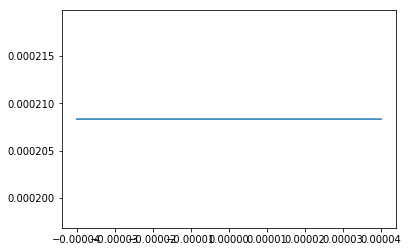

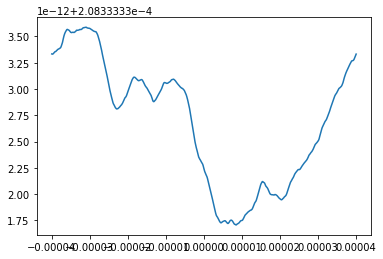

-3.9999999999978746e-05


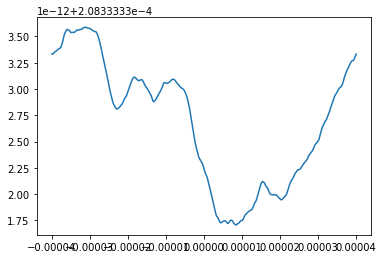

-3.9999999999978746e-05


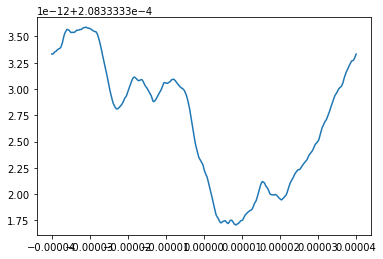

-3.9999999999978746e-05


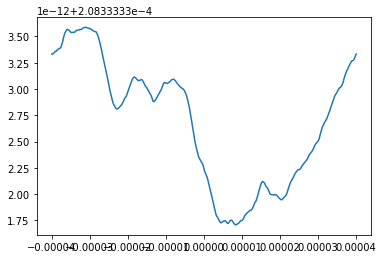

-3.9999999999978746e-05


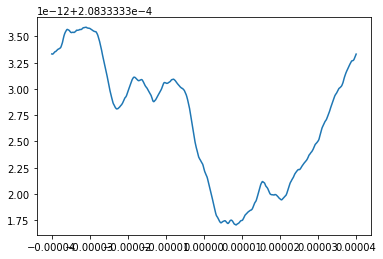

-3.9999999999978746e-05


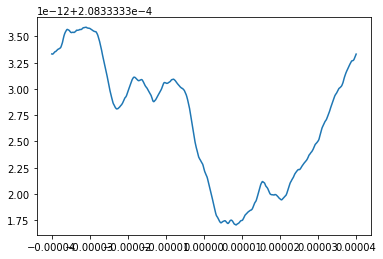

(0.9999999968586499+0j)


In [102]:
u = solve_GPE(-40*1e-6, 40*1e-6, 0, 0.1, 20*1e-3, 4800, 5000)
print(np.sum(u * np.conjugate(u)))

In [138]:
def solve_GPE_2D(xmin, xmax, ymin, ymax, tmin, tmax, dt, N, im_iters, potential):
    hbar = 1
    m  = 1.4 * 1e-25
    
    x = np.linspace(xmin, xmax, N)
    y = np.linspace(ymin, ymax, N)
    xx, yy = np.meshgrid(x, y)
    t = np.arange(tmin, tmax, dt)
    
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    u = np.ones(N*N)
    u /= np.sqrt(len(u))
    
    U = potential(xx, yy, 0).reshape(N*N)
    
    def create_matrix(sgn, u, V, interC):
        alphax = hbar**2/(4 * dx**2 * m)
        alphay = hbar**2/(4 * dy**2 * m)
        beta = (1/dt - sgn*hbar**2/(2 * dx**2 * m) \
                - sgn*hbar**2/(2 * dy**2 * m) - \
                sgn*interC/2 * (u * np.conjugate(u)) - sgn*V/2)
        A = sparse.diags([beta, sgn*alphax, sgn*alphax, sgn*alphax, sgn*alphax, \
                          sgn*alphay, sgn*alphay, sgn*alphay, sgn*alphay], \
                            [0, -1, 1, N*N - 1, 1 - N*N, -N, N, N*N - N, N - N*N],\
                         shape=(N*N, N*N), format = 'csr')
        return A
    
    
    plt.imshow((u * np.conjugate(u)).reshape(N, N))
    plt.show()
    
    for i in range(im_iters):
        if i%100 == 0:
            print(i)
        A = create_matrix(-1, u, U, 1)
        B = create_matrix(1, u, U, 1)
        
        B_gpu = csr_gpu(B)
        u_gpu = cp.array(u)
        
        b = B_gpu.dot(u_gpu)
        
        b = cp.asnumpy(b)
        
        u = splinalg.spsolve(A, b)
        #diff = unext - u
        #diff = diff * np.conjugate(diff)
        #u = unext
        
        A = some_sparse_matrix #(scipy.sparse.csr_matrix)
        x = some_dense_vector  #(numpy.ndarray)
    
    plt.imshow((u * np.conjugate(u)).reshape(N, N))
    plt.colorbar()
    plt.show()
        

In [139]:
def vortex_potential(x, y, t, alpha, beta, v):
    return 1/4 * (x**2 + y**2) + alpha * np.exp(- beta* x**2 \
                                                - beta*(y - v * t)**2) 

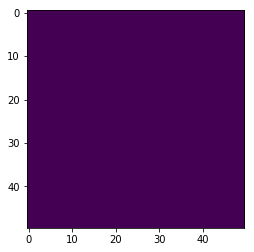

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


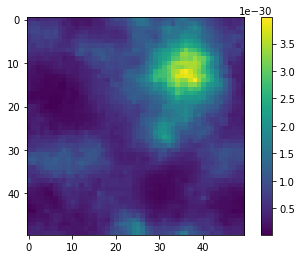

In [141]:
A = solve_GPE_2D(-5, 5, -5, 5, 0, 10, 1, \
                 50, 5000, lambda x, y, t: vortex_potential(x, y, t, 1, 1, 1))